In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'Russia'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(127564, 7)
CPU times: user 18.9 s, sys: 227 ms, total: 19.1 s
Wall time: 19.1 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,В минувший четверг президент РФ Борис Ельцин п...,Россия
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,"Мирные жители продолжают покидать Чечню, переб...",Россия


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


CPU times: user 450 ms, sys: 19.9 ms, total: 470 ms
Wall time: 469 ms


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 21.6 s, sys: 370 ms, total: 21.9 s
Wall time: 21.9 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,в минувший четверг президент рф борис ельцин п...,Россия,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,мирные жители продолжают покидать чечню переби...,Россия,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3min 45s, sys: 4.78 ms, total: 3min 45s
Wall time: 3min 45s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 5min 14s, sys: 392 ms, total: 5min 14s
Wall time: 5min 14s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[минувший, рф, борис_ельцин, подписать, указ, ..."
1,1,1999,10,"[мирный, житель, продолжать, покидать, чечня, ..."


In [14]:
print(df.shape)
df.isnull().sum()

(127564, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 1.56 s, sys: 256 ms, total: 1.82 s
Wall time: 1.84 s


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Russia", num_batches=128)
CPU times: user 58.7 s, sys: 1.13 s, total: 59.9 s
Wall time: 15.6 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=f95112da-5dc0-4810-b2e0-b84f0d87c97e, num_entries=35610)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #2am

#topic 2.........


In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

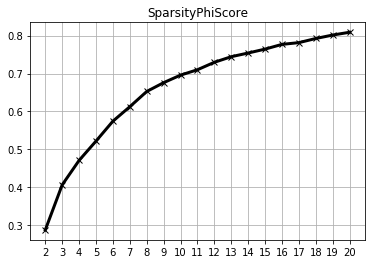

In [25]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [26]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

In [27]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 8, 0.8: 2}

Text(0.5, 1.0, 'SparsityThetaScore')

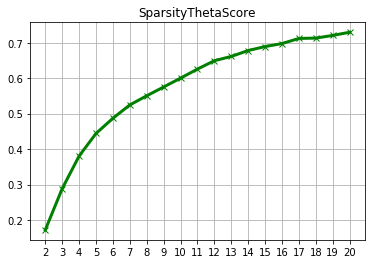

In [28]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [29]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [30]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 7, 0.7: 4}

Text(0.5, 1.0, 'PerplexityScore')

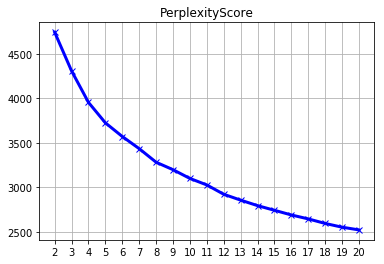

In [31]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [32]:
perplexity

[4743.140625,
 4308.1279296875,
 3954.203125,
 3724.353271484375,
 3570.958740234375,
 3434.198486328125,
 3281.608154296875,
 3197.7421875,
 3099.375732421875,
 3026.2744140625,
 2921.44140625,
 2855.5595703125,
 2793.71337890625,
 2741.35546875,
 2688.814208984375,
 2644.536376953125,
 2593.37890625,
 2551.35205078125,
 2520.802001953125]

### select the best model

In [33]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 8, 0.8: 2}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 7, 0.7: 4}


In [34]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7348448634147644
	SparsityPhiScore: 0.8095507025718689
	PerplexityScore: 2534.576171875


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['станция' 'поезд' 'линия' 'метро' 'вода' 'авария' 'движение'
 'метрополитен' 'вагон' 'ситуация']
topic_1: ['прокуратура' 'проверка' 'заявление' 'иск' 'нарушение' 'жалоба' 'подать'
 'письмо' 'судебный' 'обратиться']
topic_2: ['свобода' 'наказание' 'лишение' 'колония' 'срок' 'штраф' 'осудить'
 'приговорить' 'признать' 'административный']
topic_3: ['средство' 'миллиард' 'система' 'бюджет' 'программа' 'гражданин'
 'министерство' 'проект' 'сумма' 'министр']
topic_4: ['закон' 'совет' 'законопроект' 'федерация' 'палата' 'заседание'
 'парламент' 'поправка' 'внести' 'предложить']
topic_5: ['пожар' 'мчс' 'пожарный' 'здание' 'возгорание' 'вертолёт' 'метр' 'взрыв'
 'происшествие' 'спасатель']
topic_6: ['партия' 'выбор' 'кандидат' 'выборы' 'единый' 'избирательный' 'лидер'
 'голосование' 'кпрф' 'голос']
topic_7: ['школа' 'ребёнок' 'образование' 'вуз' 'студент' 'университет' 'наука'
 'институт' 'шахта' 'учебный']
topic_8: ['губернатор' 'пост' 'должность' 'администрация' 'отставка' 'заместит

In [33]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [34]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['станция', 'поезд', 'линия', 'метро', 'вода', 'авария', 'движение',
        'метрополитен', 'вагон', 'ситуация', 'железнодорожный', 'мчс',
        'мост', 'дорога', 'пассажир', 'край', 'режим', 'тонна', 'железный',
        'река'], dtype=object),
 'topic_1': array(['прокуратура', 'проверка', 'заявление', 'иск', 'нарушение',
        'жалоба', 'подать', 'письмо', 'судебный', 'обратиться',
        'обращение', 'требование', 'факт', 'компенсация', 'признать',
        'генпрокуратура', 'журналист', 'просьба', 'прокурор', 'утверждать'],
       dtype=object),
 'topic_2': array(['свобода', 'наказание', 'лишение', 'колония', 'срок', 'штраф',
        'осудить', 'приговорить', 'признать', 'административный',
        'нарушение', 'виновный', 'приговор', 'преступление',
        'ответственность', 'заключённый', 'правозащитник', 'лицо', 'арест',
        'правонарушение'], dtype=object),
 'topic_3': array(['средство', 'миллиард', 'система', 'бюджет', 'программа',
        'гражданин

### get topics-docs matrix

shape theta: (20, 127553)


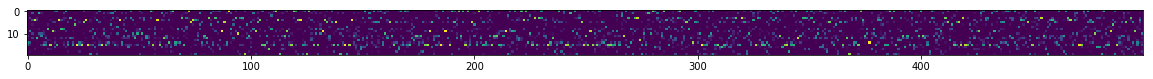

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
107000,0.000000,0.008881,0.019214,0.175356,0.096219,0.0,0.0,0.000000,0.094793,0.000000,0.000000,0.149190,0.000000,0.000000,0.000000,0.000000,0.456347,0.0,0.0,0.000000
107001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.007873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231792,0.000000,0.0,0.0,0.760335
107002,0.000000,0.000000,0.259310,0.000000,0.000000,0.0,0.0,0.000000,0.100283,0.000000,0.082426,0.362046,0.080326,0.074745,0.040865,0.000000,0.000000,0.0,0.0,0.000000
107003,0.000000,0.077054,0.102668,0.000000,0.000000,0.0,0.0,0.192073,0.000000,0.012531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.615675
107004,0.151597,0.000000,0.026564,0.000000,0.429226,0.0,0.0,0.000000,0.002854,0.000000,0.000000,0.000000,0.184256,0.134190,0.000000,0.000000,0.054235,0.0,0.0,0.017078


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.000000,0.287404,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.703095,0.000000,0.0,0.0,0.0,0.000000
1,1,1999,10,0.032170,0.000000,0.013452,0.196744,0.000000,0.041633,0.000000,...,0.0,0.329294,0.000000,0.0,0.000000,0.336956,0.0,0.0,0.0,0.030784
2,2,1999,10,0.000000,0.000000,0.000000,0.000000,0.249242,0.000000,0.066541,...,0.0,0.603826,0.078284,0.0,0.000000,0.002107,0.0,0.0,0.0,0.000000
3,3,1999,10,0.029277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.162987,0.000000,0.0,0.375566,0.432170,0.0,0.0,0.0,0.000000
4,4,1999,10,0.101882,0.144185,0.233544,0.005883,0.115881,0.000000,0.000000,...,0.0,0.187087,0.004481,0.0,0.000000,0.207057,0.0,0.0,0.0,0.000000


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0    topic_1   topic_2    topic_3    topic_4    topic_5  \
year month                                                                    
1999 8       0.402518   0.373956  0.000000   0.000000   0.212618   0.344058   
     9      10.133363   7.124042  2.098882  14.769816  14.882006  10.675741   
     10     15.597101  10.222019  1.666245  25.051987  10.982459   4.179729   
     11     14.780340  16.278244  2.004976  23.448925  14.058756   8.489236   
     12     13.509544  26.420050  4.595367  24.105007  24.286772  10.962970   

              topic_6   topic_7    topic_8   topic_9  topic_10   topic_11  \
year month                                                                  
1999 8       0.568391  0.250114   0.574094  0.039872  0.136130   0.179797   
     9      14.964467  2.938345  10.940151  2.819525  4.493350  16.427418   
     10     21.910795  2.250565   9.246507  3.069131  3.220503  12.891050   
     11     27.785114  3.613770  15.163280  5.577762  7.736338  28.332846   
     12     70.223709  2.712258  23.567692  6.171044  6.566554  35.865181   

             topic_12  topic_13   topic_14   topic_15  topic_16  topic_17  \
year month                                                                  
1999 8       0.572147  0.043679   0.547224   1.159438  0.000000  0.270875   
     9      21.837299  4.023809  10.063511  34.237774  4.605888  5.246506   
     10     11.874755  3.459850  12.462907  15.508904  5.143556  4.202509   
     11     24.097044  7.615685  18.524084  22.418182  7.639953  6.209726   
     12     33.150902  7.797503  27.653524  43.266438  9.616495  9.580700   

            topic_18  topic_19  
year month                      
1999 8      0.000000  0.325089  
     9      2.344475  9.373633  
     10     1.901986  4.157444  
     11     2.146718  6.079023  
     12     3.214722  6.733571

### straightforward matrix heatmap

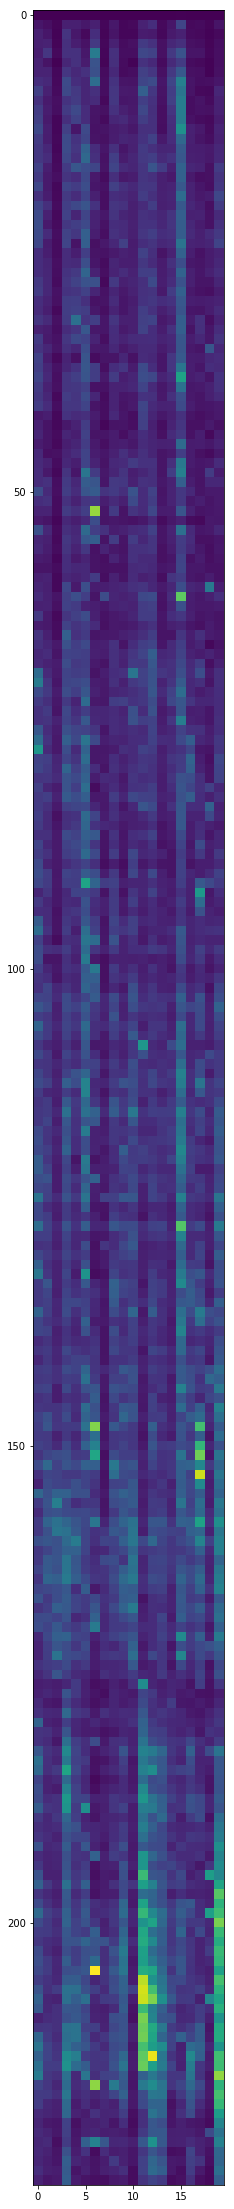

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [41]:
import pygal
from IPython.display import SVG, HTML

In [42]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [44]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [50]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(127564, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.000000,0.287404,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.703095,0.000000,0.0,0.0,0.0,0.000000
1,1,1999,10,0.032170,0.000000,0.013452,0.196744,0.000000,0.041633,0.000000,...,0.0,0.329294,0.000000,0.0,0.000000,0.336956,0.0,0.0,0.0,0.030784
2,2,1999,10,0.000000,0.000000,0.000000,0.000000,0.249242,0.000000,0.066541,...,0.0,0.603826,0.078284,0.0,0.000000,0.002107,0.0,0.0,0.0,0.000000
3,3,1999,10,0.029277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.162987,0.000000,0.0,0.375566,0.432170,0.0,0.0,0.0,0.000000
4,4,1999,10,0.101882,0.144185,0.233544,0.005883,0.115881,0.000000,0.000000,...,0.0,0.187087,0.004481,0.0,0.000000,0.207057,0.0,0.0,0.0,0.000000


In [29]:
joined.to_csv(f'./data/topicsProbability/{name_dataset}.csv',index=False)

In [52]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.000000,0.503872,0.000000,0.378198,...,0.000000,0.000000,0.0,0.11793,0.000000,0.0,0.000000,0.0,0.0,1999-10-01
1,1,1,1999,10,0.064871,0.068242,0.000000,0.135542,0.302865,0.000000,...,0.012898,0.019203,0.0,0.00000,0.387551,0.0,0.000000,0.0,0.0,1999-10-01
2,2,2,1999,10,0.000000,0.000000,0.290674,0.047509,0.017833,0.000000,...,0.641185,0.002800,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1999-10-01
3,3,3,1999,10,0.008290,0.000000,0.000000,0.000000,0.000000,0.304913,...,0.211007,0.000000,0.0,0.00000,0.475790,0.0,0.000000,0.0,0.0,1999-10-01
4,4,4,1999,10,0.084448,0.041262,0.000000,0.117841,0.140891,0.000000,...,0.137352,0.000000,0.0,0.00000,0.126674,0.0,0.014703,0.0,0.0,1999-10-01


In [53]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(3061536, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [54]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(2551280, 3)


topic_8     127564
topic_13    127564
topic_14    127564
topic_6     127564
topic_2     127564
topic_11    127564
topic_3     127564
topic_4     127564
topic_10    127564
topic_15    127564
topic_18    127564
topic_16    127564
topic_9     127564
topic_7     127564
topic_19    127564
topic_17    127564
topic_5     127564
topic_0     127564
topic_12    127564
topic_1     127564
Name: topic, dtype: int64

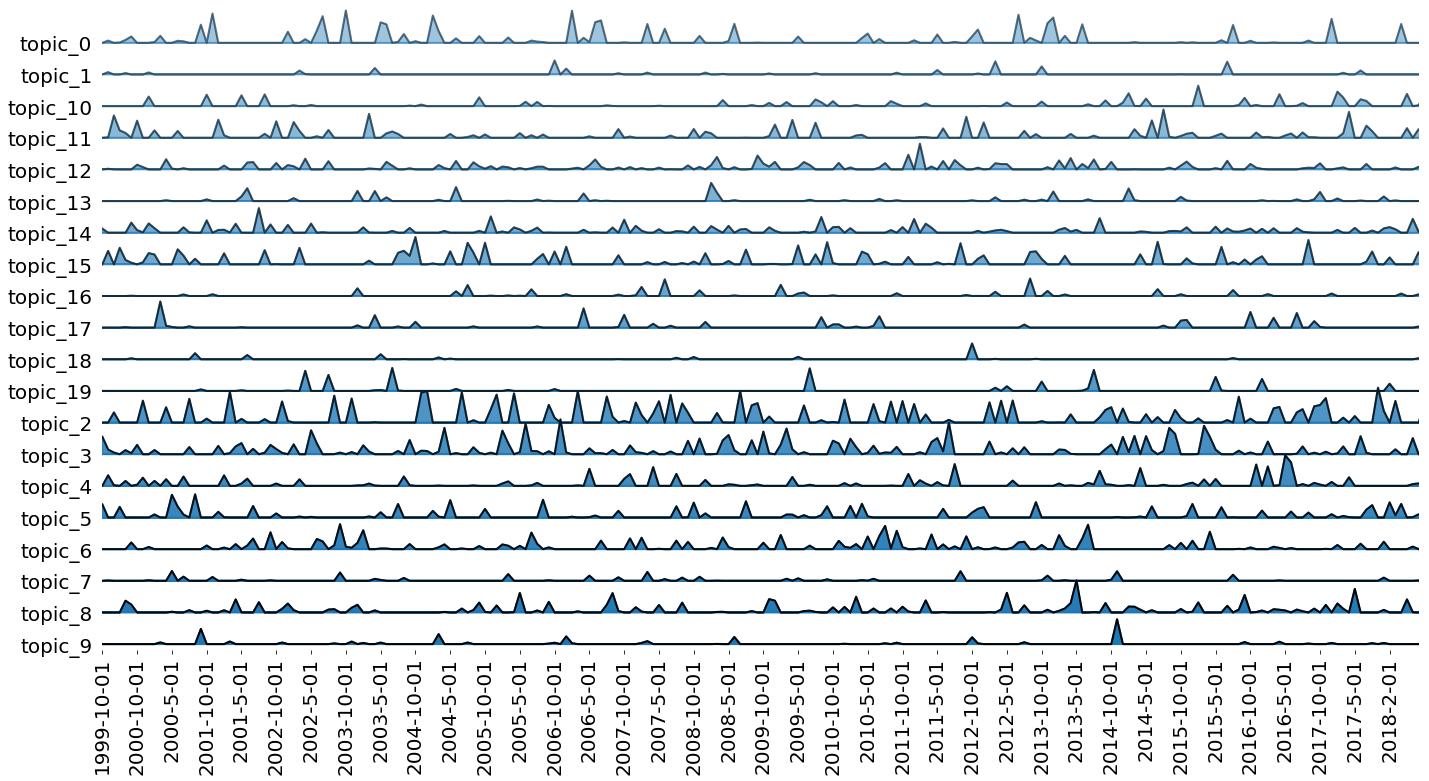

In [55]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [56]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")